## This notebook contains the code for exploring and preparing the MNITemplateAtlas files, and registering the atlases to each test sample space.  

In [27]:
import numpy as np
from EM import NiftiManager, Evaluate, EM, ElastixTransformix, FileManager
from glob import glob
import math
from tqdm import tqdm
import pprint
import pandas as pd
import nibabel as nib
import os

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
NM    = NiftiManager()
EVAL  = Evaluate()
ET    = ElastixTransformix()
FM    = FileManager()

In [29]:
intensity_atlas_path = 'MNITemplateAtlas/template.nii.gz'
tissue_4d_atlas_path = 'MNITemplateAtlas/atlas.nii.gz'

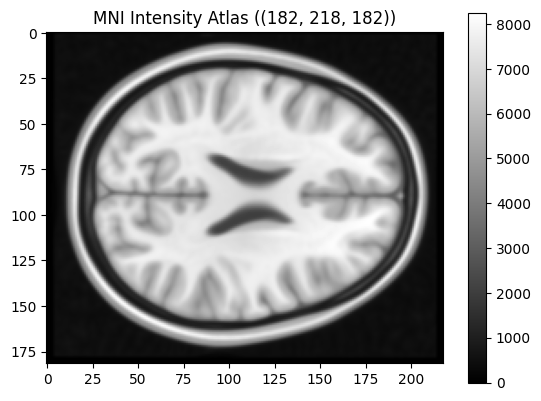

In [30]:
intensity_atlas = NM.load_nifti(intensity_atlas_path)[0]

NM.show_nifti(intensity_atlas, f'MNI Intensity Atlas ({intensity_atlas.shape})', slice=95)

(182, 218, 182, 4)


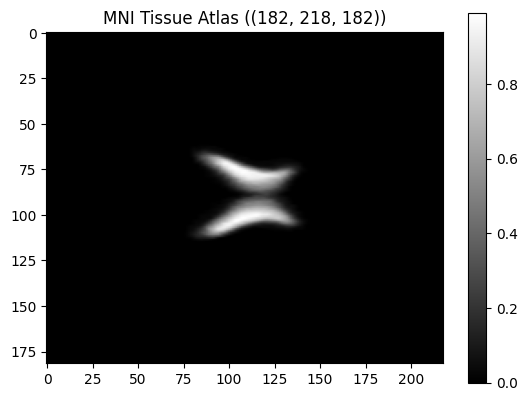

In [31]:
tissue_4d_atlas, nii_image = NM.load_nifti(tissue_4d_atlas_path)
print(tissue_4d_atlas.shape)

MNI_TISSUE_INDEX = {
    'BG': 0,
    'CSF': 1,
    'GM': 2,
    'WM': 3
}

tissue_idx = MNI_TISSUE_INDEX['CSF']

NM.show_nifti(tissue_4d_atlas[:,:,:, tissue_idx], f'MNI Tissue Atlas ({tissue_4d_atlas[:,:,:,tissue_idx].shape})', slice=95)

In [18]:
# NM.export_nifti(tissue_4d_atlas[:,:,:,MNI_TISSUE_INDEX['CSF']], 'MNITemplateAtlas/mean_csf.nii.gz', fdata=nii_image)
# NM.export_nifti(tissue_4d_atlas[:,:,:,MNI_TISSUE_INDEX['WM']], 'MNITemplateAtlas/mean_wm.nii.gz', fdata=nii_image)
# NM.export_nifti(tissue_4d_atlas[:,:,:,MNI_TISSUE_INDEX['GM']], 'MNITemplateAtlas/mean_gm.nii.gz', fdata=nii_image)

mean_csf.shape:  (182, 218, 182)
mean_wm.shape:  (182, 218, 182)
mean_gm.shape:  (182, 218, 182)


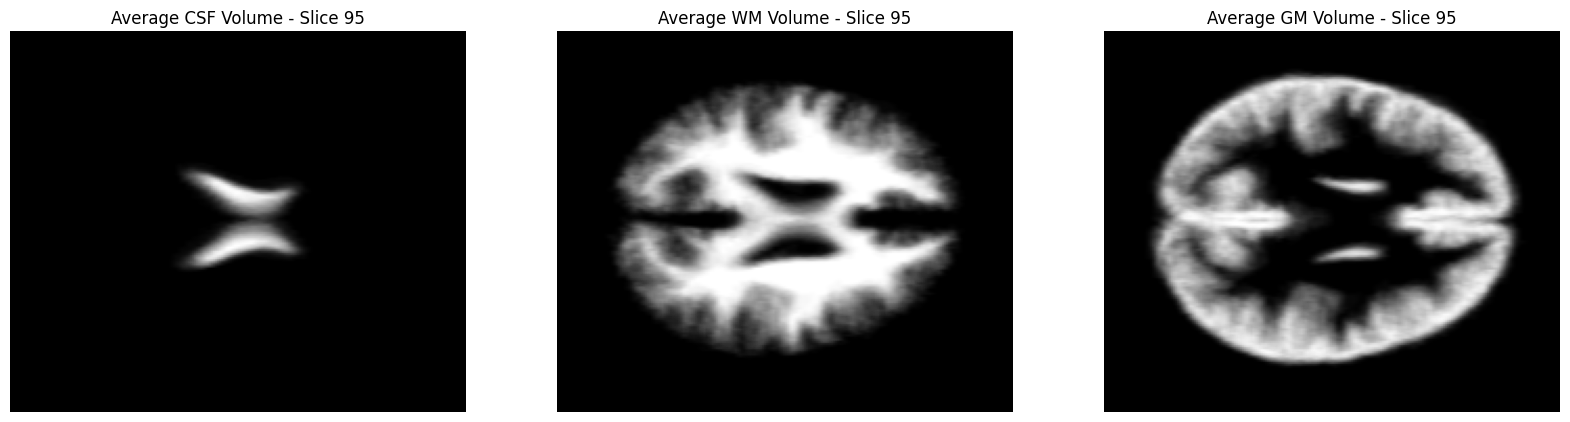

In [32]:
atlas_csf_dir = 'MNITemplateAtlas/mean_csf.nii.gz'
atlas_wm_dir  = 'MNITemplateAtlas/mean_wm.nii.gz'
atlas_gm_dir  = 'MNITemplateAtlas/mean_gm.nii.gz'

mean_csf = NM.load_nifti(atlas_csf_dir)[0]
mean_wm  = NM.load_nifti(atlas_wm_dir)[0]
mean_gm  = NM.load_nifti(atlas_gm_dir)[0]

print("mean_csf.shape: ", mean_csf.shape)
print("mean_wm.shape: ", mean_wm.shape)
print("mean_gm.shape: ", mean_gm.shape)

NM.show_mean_volumes(mean_csf, mean_wm, mean_gm, slices=[95])

Obtaining the test directories

In [33]:
test_path = 'test-set/testing-images'
test_labels_path = 'test-set/testing-labels'
test_masks_path = 'test-set/testing-mask'

test_volumes = sorted(glob(os.path.join(test_path, "*.nii.gz"), recursive=True))
test_labels = sorted(glob(os.path.join(test_labels_path, "*.nii.gz"), recursive=True))
test_masks = sorted(glob(os.path.join(test_masks_path, "*.nii.gz"), recursive=True))

# result examples
# 'test-set/testing-images\\1003.nii.gz'
# 'test-set/testing-labels\\1003_3C.nii.gz'
# 'test-set/testing-mask\\1003_1C.nii.gz'

Registering MNI atlases to patient (test) reference frame

In [34]:
atlas_csf_dir = 'MNITemplateAtlas/mean_csf.nii.gz'
atlas_wm_dir  = 'MNITemplateAtlas/mean_wm.nii.gz'
atlas_gm_dir  = 'MNITemplateAtlas/mean_gm.nii.gz'
averaged_intensity_atlas_path = 'MNITemplateAtlas/template.nii.gz'
reg_params = '-p "Par0010affine.txt" -p "Par0010bspline.txt"'

for test_volume, test_label, test_mask in tqdm(zip(test_volumes, test_labels, test_masks)):
    image_id = test_volume.replace('\\', '/').split("/")[-1].split(".")[0]
    reg_moving_name = averaged_intensity_atlas_path.replace("\\", "/").split("/")[-1].split(".")[0]

    # register an example test volume to the averaged intensity atlas
    ET.register_elastix(
        fixed_path = test_volume, 
        moving_path = averaged_intensity_atlas_path,
        fMask = test_mask,
        reg_params = reg_params,
        create_dir_callback = FM.create_directory_if_not_exists,
        excute_cmd_callback = ET.excute_cmd)

    # perform label propagation to csf atlas
    ET.label_propagation_transformix(
        fixed_path = test_volume, 
        moving_path = atlas_csf_dir, 
        input_label = atlas_csf_dir,
        transform_path = f'output/images/output_{image_id}/{reg_moving_name}/TransformParameters.1.txt',
        replace_text_in_file_callback = FM.replace_text_in_file,
        create_dir_callback = FM.create_directory_if_not_exists,
        excute_cmd_callback = ET.excute_cmd)

    # perform label propagation to wm atlas
    ET.label_propagation_transformix(
        fixed_path = test_volume, 
        moving_path = atlas_wm_dir, 
        input_label = atlas_wm_dir,
        transform_path = f'output/images/output_{image_id}/{reg_moving_name}/TransformParameters.1.txt',
        replace_text_in_file_callback = FM.replace_text_in_file,
        create_dir_callback = FM.create_directory_if_not_exists,
        excute_cmd_callback = ET.excute_cmd)

    # perform label propagation to gm atlas
    ET.label_propagation_transformix(
        fixed_path = test_volume, 
        moving_path = atlas_gm_dir, 
        input_label = atlas_gm_dir,
        transform_path = f'output/images/output_{image_id}/{reg_moving_name}/TransformParameters.1.txt',
        replace_text_in_file_callback = FM.replace_text_in_file,
        create_dir_callback = FM.create_directory_if_not_exists,
        excute_cmd_callback = ET.excute_cmd)


20it [54:14, 162.75s/it]
